In [1]:
from unet_model import UNet
import numpy as np
import matplotlib.pyplot as plt
import torch
from PIL import Image

from seep_dataset import SeepImageDataset
from torch.utils.data import DataLoader, random_split
from utils import ImageHelperFunctions, ImageTransformFunctions

In [2]:
IMAGE_DIR = "./seep_detection/images_256/"
MASK_DIR = "./seep_detection/masks_256/"
BATCH_SIZE = 8

transform = ImageTransformFunctions()
helper = ImageHelperFunctions()

device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
model = UNet(1, 8).to(device)
model.load_state_dict(torch.load("./models/FocalLoss_milesialUnet_[1, 20, 40, 40, 40, 20, 20, 80]_p=300_no_val_lr=0.01"))

<All keys matched successfully>

In [4]:
dataset = SeepImageDataset(IMAGE_DIR, MASK_DIR)
#n_val = int(np.floor(0.1 * len(dataset)))
n_test = int(np.floor(0.1 * len(dataset)))
n_train = len(dataset) - n_test

train_ds, test_ds = random_split(dataset, [n_train, n_test])

In [5]:
train_loader = DataLoader(
    dataset = train_ds,
    batch_size = BATCH_SIZE,
    shuffle = True
)

test_loader = DataLoader(
    dataset = test_ds,
    batch_size = BATCH_SIZE,
    shuffle = True
)


mu, std = helper.find_mu_and_std(test_loader)

mu = mu.numpy()
std = std.numpy()

print(mu, std)

[-0.00056056] [1.0199932]


In [6]:
images, masks = next(iter(train_loader))

images = images.to(device)
masks = masks.to(device)
model.eval()
with torch.no_grad():
    test_preds = model(images)
    
print(masks.shape, images.shape, test_preds.shape)

torch.Size([8, 256, 256]) torch.Size([8, 1, 256, 256]) torch.Size([8, 8, 256, 256])


In [7]:
images = images.cpu().numpy()
masks = masks.cpu().numpy()
test_preds = test_preds.cpu().numpy()

classes: [0 1]
counts: [65134   402]
mask: (array([0, 1], dtype=uint8), array([65134,   402], dtype=int64))
classes: [0 1]
counts: [64821   715]
pred: (array([0, 1], dtype=uint8), array([64821,   715], dtype=int64))


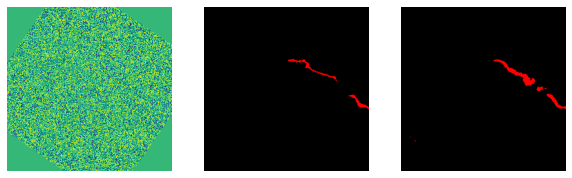

classes: [0 1 2]
counts: [64906   326   304]
mask: (array([0, 1, 2], dtype=uint8), array([64906,   326,   304], dtype=int64))
classes: [0 1 7]
counts: [63022  2507     7]
pred: (array([0, 1, 7], dtype=uint8), array([63022,  2507,     7], dtype=int64))


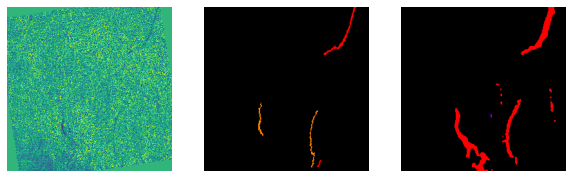

classes: [0 1 2]
counts: [64737   143   656]
mask: (array([0, 1, 2], dtype=uint8), array([64737,   143,   656], dtype=int64))
classes: [0 1 7]
counts: [63922  1609     5]
pred: (array([0, 1, 7], dtype=uint8), array([63922,  1609,     5], dtype=int64))


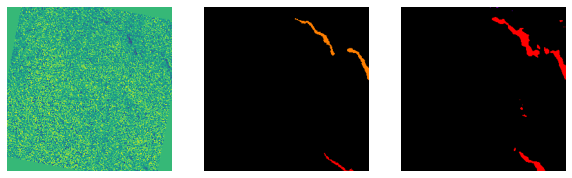

classes: [0 1]
counts: [65056   480]
mask: (array([0, 1], dtype=uint8), array([65056,   480], dtype=int64))
classes: [0 1 7]
counts: [59556  5974     6]
pred: (array([0, 1, 7], dtype=uint8), array([59556,  5974,     6], dtype=int64))


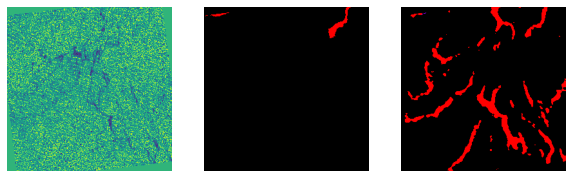

classes: [0 1]
counts: [64510  1026]
mask: (array([0, 1], dtype=uint8), array([64510,  1026], dtype=int64))
classes: [0 1 7]
counts: [64876   656     4]
pred: (array([0, 1, 7], dtype=uint8), array([64876,   656,     4], dtype=int64))


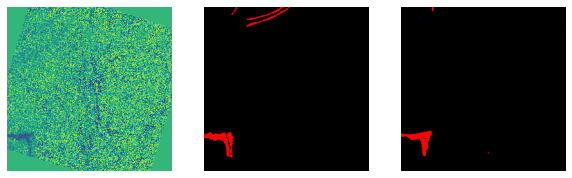

classes: [0 1 2 7]
counts: [64406   725    58   347]
mask: (array([0, 1, 2, 7], dtype=uint8), array([64406,   725,    58,   347], dtype=int64))
classes: [0 1]
counts: [65086   450]
pred: (array([0, 1], dtype=uint8), array([65086,   450], dtype=int64))


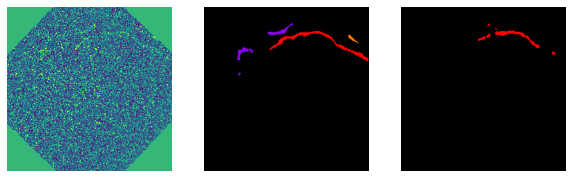

classes: [0 2]
counts: [65437    99]
mask: (array([0, 2], dtype=uint8), array([65437,    99], dtype=int64))
classes: [0 1 7]
counts: [64454  1070    12]
pred: (array([0, 1, 7], dtype=uint8), array([64454,  1070,    12], dtype=int64))


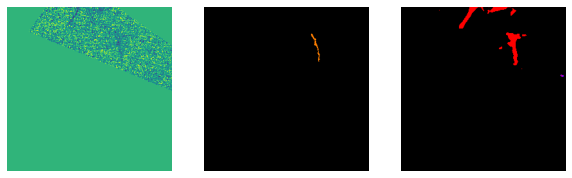

classes: [0 1 6]
counts: [55992  5554  3990]
mask: (array([0, 1, 6], dtype=uint8), array([55992,  5554,  3990], dtype=int64))
classes: [0 1 7]
counts: [50735 14717    84]
pred: (array([0, 1, 7], dtype=uint8), array([50735, 14717,    84], dtype=int64))


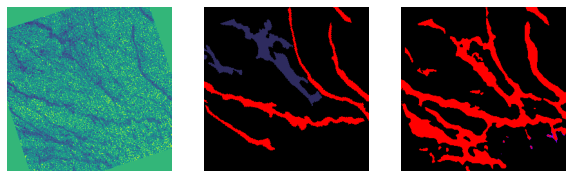

In [8]:
for i in range(images.shape[0]):
    image = images[i, :, :]
    mask = masks[i, :, :]
    pred = test_preds[i, :, :, :]
    
    image = transform.inv_normalize(image, mu, std)
    
    mask = mask.astype(np.uint8)
    mask = Image.fromarray(mask, 'L')
    print(f"mask: {helper.count_classes_in_arr(mask)}") 
    mask = transform.mask_to_palette(mask)
    
    pred = np.where(pred > 0.5,1,0)
    pred = transform.onehot_to_mask(pred)
    print(f"pred: {helper.count_classes_in_arr(pred)}")
    pred = transform.mask_to_palette(pred)
    
    helper.preview_images((image, mask, pred))
    